In [49]:
import os
import sys
import glob
import math
import pandas as pd
import subprocess
from multiprocessing import Pool
import multiprocessing 
from collections import Counter

from matplotlib import cm
import matplotlib
import umap
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from biopandas.pdb import PandasPdb

sys.path.append('../../hamp_pred/')
from utils.tools import diffangle


data_dir = '../../data/input'

In [2]:
def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    #plt.register_cmap(cmap=newcmap)

    return newcmap

# Read data

In [3]:
# get group names
hamp_groups_df = pd.read_csv('../../../TCST/offline_data/hamp/groupnames.csv', names=['paper_group', 'group'])
hamp_groups_df['group'] = hamp_groups_df['group'].apply(lambda x:x.replace('.fas', ''))
paper2group = dict(hamp_groups_df.values) #my_array
group2paper = dict(hamp_groups_df.values[:, [1, 0]])


NEW_RUN = '_newrun'
#NEW_RUN = ''

# get measured structures from af2
data_df = pd.read_pickle(os.path.join(data_dir, f'af2{NEW_RUN}.p'))
data_df.group = data_df.group.apply(lambda x:group2paper[x] if x in group2paper else '?')
len(data_df)

5314

In [4]:
data_df.to_pickle('/home/users/sdunin/tmp/hamp.p')

In [5]:
CLEAN = True

In [6]:
# remove background sequences
#if CLEAN:
#    data_df = data_df[data_df.group != '?']

In [7]:
# calculate the relative rotation (i.e., the per-layer difference between N and C helices rotation) 
data_df['rot'] = diffangle(data_df.n_crick_mut, data_df.c_crick_mut)
data_df['rot_mean'] = data_df['rot'].apply(np.mean)
data_df['rot_std'] = data_df['rot'].apply(np.std)
data_df['sequence'] = data_df['n_seq'] + data_df['c_seq'] # for mmseqs2 clustering

len(data_df)

5314

In [8]:
# referece Crick angles
crangles = {'a':19.5,'b':122.35,'c':-134.78,'d': -31.92,'e':70.92 ,'f':173.78,'g':-83.35}

def check_crick(row, MAXROT=55):
    return (np.abs(diffangle(row.n_crick_mut[:2].mean(), crangles['a'])) <= MAXROT) and \
           (np.abs(diffangle(row.c_crick_mut[:2].mean(), crangles['a'])) <= MAXROT) 

if CLEAN:
    data_df = data_df[data_df.apply(check_crick, axis=1)]
len(data_df)

5116

In [9]:
if CLEAN:
    data_df = data_df[data_df.rot_mean.abs() <= 52]
len(data_df)

5094

In [10]:
data_df.head()

,group,n_rot,c_rot,rot,n_seq,c_seq,n_crick_mut,c_crick_mut,full_seq,pdb_file,...,c_shift,n_radius,c_radius,n_A,c_A,n_P,c_P,rot_mean,rot_std,sequence
idx,,,,,,,,,,,,,,,,,,,,,
0,A.44,-4.253356,-6.102671,"[-3.1940266412681524, -3.09708869604691, -1.86...",PLKELVQGVQRIA,EIGELITSFNLMA,"[17.23886295140168, 17.338808097449405, 119.88...","[20.43288959266982, 20.43589679349633, 121.751...",LTITQPLKELVQGVQRIAQGNFKQRVTLAYPGEIGELITSFNLMAQ...,0/hamp_0_A_group_13_unrelaxed_rank_001_alphafo...,...,-0.535204,7.260080,7.392253,13.895761,9.842634,3.531971,3.561835,1.849316,3.302544,PLKELVQGVQRIAEIGELITSFNLMA
1,A.44,-1.772898,-6.827347,"[2.114646640775419, 2.2080379205556824, 2.3345...",PIRELVEGVRSIA,ELGELIASFNDMA,"[19.59915045983829, 19.705316432140254, 122.47...","[17.48450381906287, 17.49727851158457, 120.137...",LIITRPIRELVEGVRSIASGNFKQRIDLPPSGELGELIASFNDMAE...,1/hamp_1_A_group_13_unrelaxed_rank_001_alphafo...,...,-0.419916,7.102457,7.454388,13.652361,10.171086,3.532615,3.559879,5.054449,1.934466,PIRELVEGVRSIAELGELIASFNDMA
2,A.44,-1.134666,-10.133087,"[9.966841309961325, 10.01008261948752, 7.37222...",PIKELLDGVKNIA,ELGELIVNFNEMA,"[21.211074275580728, 21.26385343164006, 121.91...","[11.244232965619398, 11.253770812152547, 114.5...",LTITRPIKELLDGVKNIAAGNFEQRIDLPFGGELGELIVNFNEMAE...,2/hamp_2_A_group_13_unrelaxed_rank_001_alphafo...,...,-0.382764,7.122620,7.707499,14.499672,13.286384,3.527494,3.545542,8.998421,2.241493,PIKELLDGVKNIAELGELIVNFNEMA
14,A.44,-2.580087,-11.125609,"[4.346169004965304, 4.44126394411964, 4.697742...",PLSELRKGIRRVA,ELGDLILQFNDMG,"[19.108465717722527, 19.328004077268492, 121.0...","[14.762296712757218, 14.886740133148859, 116.3...",ITITGPLSELRKGIRRVADGNFSHKINLVFNGELGDLILQFNDMGK...,3/hamp_14_A_group_13_unrelaxed_rank_001_alphaf...,...,-0.565854,7.366175,7.522413,12.078118,7.555782,3.543228,3.580512,8.545522,2.617987,PLSELRKGIRRVAELGDLILQFNDMG
15,A.44,-1.393935,-8.005944,"[6.200079342652373, 6.504301658689087, 5.11068...",PVKELLRGVRAVA,ELGELVNGFNDMA,"[22.18645406316231, 22.394373895126932, 123.30...","[15.986374720509943, 15.890072236437858, 118.1...",LTLTHPVKELLRGVRAVANGDFQARIVLSVSGELGELVNGFNDMAS...,4/hamp_15_A_group_13_unrelaxed_rank_001_alphaf...,...,-0.349027,7.150781,7.584602,11.548632,10.740066,3.544687,3.560871,6.612009,2.389794,PVKELLRGVRAVAELGELVNGFNDMA


# Run FoldSeek

In [11]:
# get symlinks to all pdb files

pdb_dir = f'/home/users/sdunin/calc/HAMPpred/data/input/af2_full{NEW_RUN}/'

clust_dir = f'/home/users/sdunin/calc/TCST/HAMP_AF2_cluster{NEW_RUN}/'
ln_dir = clust_dir + '/pdbs'

f = open(os.path.join(clust_dir, 'chain_list'), 'w')

for i, row in tqdm(data_df.iterrows(), total=len(data_df)):
    os.system(f'ln -sf {os.path.join(pdb_dir,row.pdb_file)} {ln_dir}')
    
    f.write(f'{os.path.basename(row.pdb_file)}\n')
     
f.close()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5094/5094 [01:25<00:00, 59.49it/s]


In [12]:
# merge chains 
in_pdbs = f'/home/users/sdunin/calc/TCST/HAMP_AF2_cluster{NEW_RUN}/pdbs/'

def merge_chains(pdb1, pdb2):

    model = PandasPdb().read_pdb(pdb1)
    model_df = model.df['ATOM']

    # Calculate res_count
    res_count = model_df[model_df.chain_id == 'A']['residue_number'].max()

    # Iterate through rows where chain_id is 'B'
    for res_id, g in model_df[model_df.chain_id == 'B'].groupby('residue_number'):
        model_df.loc[g.index, 'residue_number'] = res_id + res_count

    ca_residue_numbers = model_df[model_df.atom_name == 'CA']['residue_number']
    assert ca_residue_numbers.is_unique and ca_residue_numbers.is_monotonic_increasing

    model_df.chain_id = 'A'
    
    model.to_pdb(path=pdb2, 
            records=None, 
            gz=False, 
            append_newline=True)
    
for in_pdb in tqdm(glob.glob(os.path.join(in_pdbs, '*.pdb'))):
    out_pdb = in_pdb.replace('/pdbs/', '/pdbs_onechain/')
    merge_chains(in_pdb, out_pdb)
    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5094/5094 [07:11<00:00, 11.79it/s]


In [95]:
# run foldseek in /home/users/sdunin/calc/TCST/HAMP_AF2_cluster

# Read FoldSeek results

In [303]:
clu_results = f'/home/users/sdunin/calc/TCST/HAMP_AF2_cluster{NEW_RUN}/aln.csv'
res_df = pd.read_csv(clu_results, names=['query','target','lnlen','evalue','alntmscore','prob', 'lddt'], sep='\t')
res_df.head()

,query,target,lnlen,evalue,alntmscore,prob,lddt
0,hamp_1420_C_group_131_unrelaxed_rank_001_alpha...,hamp_1420_C_group_131_unrelaxed_rank_001_alpha...,108,1.0000,1.0000,1.000,1.0000
1,hamp_1420_C_group_131_unrelaxed_rank_001_alpha...,hamp_5991_BACKGROUND_unrelaxed_rank_001_alphaf...,108,0.9889,0.9924,0.999,0.9683
2,hamp_1420_C_group_131_unrelaxed_rank_001_alpha...,hamp_5923_BACKGROUND_unrelaxed_rank_001_alphaf...,108,0.9869,0.9910,0.999,0.9573
3,hamp_1420_C_group_131_unrelaxed_rank_001_alpha...,hamp_1427_C_group_131_unrelaxed_rank_001_alpha...,108,0.9850,0.9897,0.999,0.9671
4,hamp_1420_C_group_131_unrelaxed_rank_001_alpha...,hamp_5953_BACKGROUND_unrelaxed_rank_001_alphaf...,108,0.9843,0.9890,0.999,0.9659


In [304]:
# remove hits with low coverage
#res_df = res_df[res_df.lnlen >= 100]

In [305]:
# map to data_df indexes
pdb2idx = {v.split('/')[1]:k for k,v in zip(data_df.index, data_df['pdb_file'])}
res_df['i'] = res_df['query'].apply(lambda x:pdb2idx[x] if x in pdb2idx else -1)
res_df['j'] = res_df['target'].apply(lambda x:pdb2idx[x] if x in pdb2idx else -1)
pre_len = len(res_df)
print(pre_len)
# remove hits that involve structures that are not in data_df
res_df = res_df[(res_df['i'] != -1) & (res_df['j'] != -1)]
post_len = len(res_df)
if not CLEAN: assert pre_len == post_len


25925264


In [306]:
res_df.head()

,query,target,lnlen,evalue,alntmscore,prob,lddt,i,j
0,hamp_1420_C_group_131_unrelaxed_rank_001_alpha...,hamp_1420_C_group_131_unrelaxed_rank_001_alpha...,108,1.0000,1.0000,1.000,1.0000,1420,1420
1,hamp_1420_C_group_131_unrelaxed_rank_001_alpha...,hamp_5991_BACKGROUND_unrelaxed_rank_001_alphaf...,108,0.9889,0.9924,0.999,0.9683,1420,5991
2,hamp_1420_C_group_131_unrelaxed_rank_001_alpha...,hamp_5923_BACKGROUND_unrelaxed_rank_001_alphaf...,108,0.9869,0.9910,0.999,0.9573,1420,5923
3,hamp_1420_C_group_131_unrelaxed_rank_001_alpha...,hamp_1427_C_group_131_unrelaxed_rank_001_alpha...,108,0.9850,0.9897,0.999,0.9671,1420,1427
4,hamp_1420_C_group_131_unrelaxed_rank_001_alpha...,hamp_5953_BACKGROUND_unrelaxed_rank_001_alphaf...,108,0.9843,0.9890,0.999,0.9659,1420,5953


In [292]:
# rescale e-value
res_df['evalue'] = res_df.evalue.apply(lambda x: 1 / (1 + x) )


### Create matrix

In [293]:
res_df.columns

Index(['query', 'target', 'lnlen', 'evalue', 'alntmscore', 'prob', 'lddt', 'i',
       'j'],
      dtype='object')

In [294]:
matrix_df = res_df.pivot(index='i', columns='j', values='evalue')

In [295]:

# use 0 or mean for alntmscore
matrix_df = matrix_df.fillna(matrix_df.mean())

matrix_array = matrix_df.to_numpy()
assert matrix_array.shape[0] == matrix_array.shape[1] == len(data_df)
matrix_array.shape

(5094, 5094)

In [296]:
matrix_array

array([[0.5       , 0.50856939, 0.50436274, ..., 0.54848618, 0.56025548,
        0.59375371],
       [0.50856939, 0.5       , 0.50900947, ..., 0.55084279, 0.56239807,
        0.59467174],
       [0.50436274, 0.50900947, 0.5       , ..., 0.55466193, 0.5675691 ,
        0.59644519],
       ...,
       [0.54848618, 0.55084279, 0.55466193, ..., 0.5       , 0.52803886,
        0.59438897],
       [0.56025548, 0.56239807, 0.5675691 , ..., 0.52803886, 0.5       ,
        0.60422961],
       [0.59375371, 0.59467174, 0.59644519, ..., 0.59438897, 0.60422961,
        0.5       ]])

# Plot

### Reduce with UMAP

In [297]:
# UMAP

# If the metric is ‘precomputed’ X must be a square distance matrix. 
umap_result = umap.UMAP(
    n_neighbors = 300, 
    metric = 'precomputed',
    random_state = 123
).fit_transform(1-matrix_array)


/home/users/sdunin/miniconda3/envs/jup/lib/python3.10/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


### Color by features

In [298]:
def feature_colors(mode):
    
    assert mode in ['shift', 'rotation', 'romboid', 'angle']

    if mode == 'shift':
        title = "Shift between N- and C-terminal helices [Å]"
    elif mode == 'rotation':
        title = 'Axial rotation of all helices [°]'
    elif mode == 'romboid':
        title = 'Difference between $n_1$ and $n_2$ [Å]'
    elif mode == 'angle':
        title = 'Bundle periodicity'

    def enc(row, mode):

        if mode == 'shift':
            return (row.n_shift - row.c_shift) / 2
        elif mode == 'rotation':
            return diffangle(row.n_crick_mut , row.c_crick_mut).mean() / 2
            #return row.rot_mean / 2

        elif mode == 'romboid':
            return row.n_radius - row.c_radius

        elif mode == 'angle':
            return np.mean([row.n_P,row.c_P])

        #a = row.rot
        #return np.mean((a[0::2] + a[1::2]) / 2) / 2


    c = [enc(data_df.loc[i], mode=mode) for i in matrix_df.index]
    c = np.array(c)

    # remove outliers
    z_scores = (c - np.mean(c)) / np.std(c)
    correct_mask = abs(z_scores) <= 3
    c = c[correct_mask]

    # define cmap centered at data mean
    cmap = cm.seismic
    min_value = min(c)
    max_value = max(c)
    c_scaled = [(x - min_value) / (max_value - min_value) for x in c]
    cmap = shiftedColorMap(cmap, midpoint=np.mean(c_scaled), name='seismic_new')

    return c,correct_mask, cmap, title


### Color by groups

In [299]:
def groups_colors(gr, z_score_cut):

    # define colors for groups defined in 'gr'
    def assign_colors_to_strings(group_labels, group_colors, X=1):
        color_dict = {}

        for g in group_labels:
            if g in group_colors:
                color_dict[g] = group_colors[g]
            else:
                color_dict[g] = 'grey'

        colors = [color_dict[g] for g in group_labels]

        return colors

    group_labels = [data_df.loc[i].group for i in matrix_df.index]
    c = assign_colors_to_strings(group_labels, gr, X=10)
    c = np.array(c)
    
    # mask outliers (probable alignment errors)
    full_pos = np.array(range(len(matrix_df.index)))
    to_remove = []
    
    # groups
    for g in gr:
        # positions (not indexes) of sequences from group `g`        
        pos = np.where(c == gr[g])[0]
        
        # cooridnates in the UMAP space
        x = umap_result[pos, 0]
        y = umap_result[pos, 1]
        
        # outlier detection
        z_scores_x = (x - np.mean(x)) / np.std(x)
        z_scores_y = (y - np.mean(y)) / np.std(y)
        
        tr = pos[
            (np.abs(z_scores_x) > z_score_cut) | (np.abs(z_scores_y) > z_score_cut)
        ]
        
        for tmp in tr: 
            assert not tmp in to_remove
            assert tmp in full_pos, tmp
            
        to_remove.extend(tr)
     
    assert len(set(to_remove)) == len(to_remove)
    print(f'{len(to_remove)} points will be removed from {len(gr)} groups...')
                
    mask = np.isin(full_pos, to_remove, invert=True)
    #c = c[mask]
    
    return c, mask


### Plot

In [300]:
# color by feature
c, correct_mask, cmap, title = feature_colors('angle')

In [301]:
# color by groups
# B        300 B, F2-B
# C.1      155
# A.28     145
# D        130
# F.2      107 F2-B 
# A.48      56

gr = {    
    'B':'limegreen', 
    'F.2':'orange', 
    'A.28':'skyblue',
    'D':'violet',
    
    
    'G.1':'red',

    
    'F.6':'blue'
    
    #'A.48':'blue',
    #'C.1':'blue', 
}  

c, correct_mask = groups_colors(gr, z_score_cut=13)
cmap = None

0 points will be removed from 6 groups...


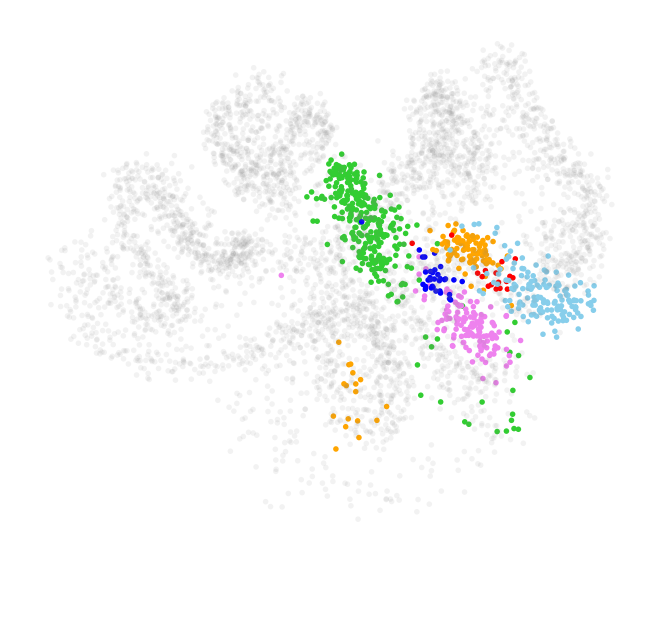

In [302]:
label_font_size = 10
tick_font_size = 9 # bar
title_font_size = 10

fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=200)

ax.set_axis_off()

gs = fig.add_gridspec(2, 1, height_ratios=[1, 0.05])  # 2 columns, 1 for scatter plot, 1 for color bar
ax = fig.add_subplot(gs[0])
ax.set_axis_off()

# for plotting with colormap
if cmap is not None:
    scatter = ax.scatter(umap_result[correct_mask, 0], umap_result[correct_mask, 1], s=0.5, c=c, cmap=cmap)  # Adjust 's' for point size    
    
    # Create the color bar
    cbar_ax = fig.add_subplot(gs[1])
    cbar = fig.colorbar(scatter, cax=cbar_ax, orientation='horizontal')
    cbar.ax.tick_params(labelsize=tick_font_size)  
    cbar.set_label(title, fontsize=title_font_size)
    
    cbar.outline.set_linewidth(0)

    
    # Adjust layout to ensure the scatter plot maintains its size
    
        
# for ploting without colormap
else:
    
    non_grey_indices = (c != 'grey') & correct_mask
    grey_indices = (c == 'grey') & correct_mask
    
    scatter = plt.scatter(umap_result[non_grey_indices, 0], umap_result[non_grey_indices, 1], s=4, c=c[non_grey_indices],
                         edgecolor='none')
    
    scatter = plt.scatter(umap_result[grey_indices, 0], umap_result[grey_indices, 1], s=4, c=c[grey_indices], zorder=1,
                        alpha=0.1, edgecolor='none')


#plt.tight_layout()


# Old

# Cluster embeddings (not used)

In [202]:
data_full_df = pd.read_pickle(os.path.join(data_dir, 'af2.p'))
data_full_df.group = data_full_df.group.apply(lambda x:group2paper[x] if x in group2paper else '?')
len(data_full_df)

5314

In [148]:
af2_path = '/home/nfs/rmadaj/hamp/HAMPpred/clustering/af2_structures'


In [263]:

index = []
embs = []

for n in tqdm(range(5001)):

    pdb_files = glob.glob(os.path.join(af2_path, str(n), '*_pair_repr_*rank_001*.npy'))
    assert len(pdb_files)==1

    pdb_file = pdb_files[0]
    embs.append(np.load(pdb_file).mean(axis=(0, 1)))

    idx = int(os.path.basename(pdb_file).split('_')[1])
    index.append(idx)
    
    #break
    
for i in index:
    assert i in data_full_df.index, i
    
embs = np.array(embs)
embs.shape

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5001/5001 [01:53<00:00, 44.24it/s]


(5001, 128)

In [264]:
# UMAP

# If the metric is ‘precomputed’ X must be a square distance matrix. 
umap_result = umap.UMAP(n_neighbors=50, metric='cosine').fit_transform(embs)


In [268]:
def enc(row):
    
    # shift
    #return (row.n_shift - row.c_shift) / 2

    # rotation
    return diffangle(row.n_crick_mut , row.c_crick_mut).mean() / 2
    
    # romboid
    #return row.n_radius - row.c_radius 
    

    
    # global crossing angle
    return np.mean([row.n_A,row.c_A])

In [269]:
c = [enc(data_full_df.loc[i]) for i in index]

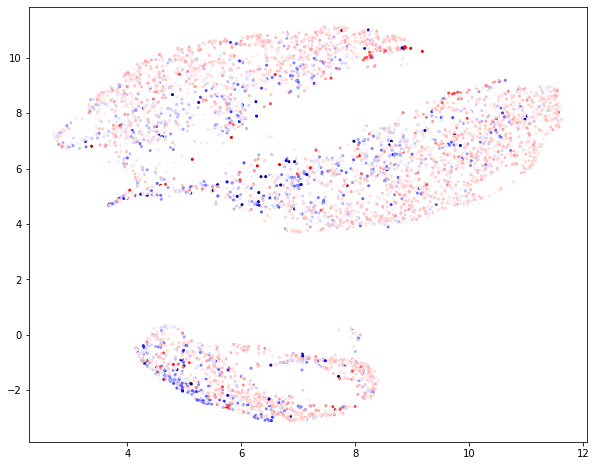

In [270]:
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed

# Create a scatter plot with a color bar
scatter = plt.scatter(umap_result[:, 0], umap_result[:, 1], s=4, c=c, cmap=cmap)  # Adjust 's' for point size


In [256]:
umap_result.shape

(5001, 2)

In [17]:


def run_multiprocess(func, tasks, n_cores, tasks_per_core=1):
        
    stdout_queue = multiprocessing.Queue()
    pool = multiprocessing.Pool(processes=n_cores, initargs=[stdout_queue], maxtasksperchild=tasks_per_core)
    for i, data in enumerate(pool.starmap(func, tasks), 1):
        yield data
    pool.close()
    pool.join()



In [29]:

pdb_dir = '/home/users/sdunin/calc/HAMPpred/data/input/af2_full'
usexecutable = '/home/users/sdunin/apps/USalign/USalign'

def align(i,j,pdb1, pdb2):
    usexecutable = '/home/users/sdunin/apps/USalign/MMalign'
    
    align_res = subprocess.run(
        [usexecutable, pdb1, pdb2, '-mm', '1', '-ter', '0', '-outfmt', '2'],
        capture_output=True, text=True
    )
    res = align_res.stdout.split('\n')[1].split('\t')
    return [i,j]+res

num_cpus = 15
pool = Pool(processes=num_cpus)

#max_index = len(data_df.index)
max_index = 100

print('generating jobs...')

jobs = []

for i in range(max_index):
    idx1 = data_df.index[i]
    row1 = data_df.loc[idx1]
    pdb1 = os.path.join(pdb_dir, row1.pdb_file)
    
    for j in range(i + 1, max_index):
        idx2 = data_df.index[j]
        row2 = data_df.loc[idx2]
        pdb2 = os.path.join(pdb_dir, row2.pdb_file)

        jobs.append((idx1, idx2, pdb1, pdb2))

jobs_count = len(jobs)
print(f'running {jobs_count} jobs on {num_cpus} cpus...')
        
results = []      
with tqdm(total=jobs_count) as pbar:       
    for res in run_multiprocess(align, jobs, 10):
        results.append(res)
        assert len(res)==13
        pbar.update(10)

generating jobs...
running 4950 jobs on 15 cpus...


49500it [00:38, 1282.17it/s]                                                                                                                                  


In [ ]:
head = ['i', 'j', 'PDBchain1', 'PDBchain2', 'TM1', 'TM2', 'RMSD', 'ID1', 'ID2', 'IDali', 'L1', 'L2', 'Lali']
res_df = pd.DataFrame(results, columns=head)
res_df.to_pickle('./tmp/AF2_clust.p')

In [25]:
len(data_df)

150